# Предсказание количества заболевших (абсолютной инциденции)

## Подготовленные данные
Импорт исходных данных (по умолчанию - файл ***COVID_PSK.csv***)

In [221]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

from load_csv_silent import QuickLoad


X,l,ts,df1,df = QuickLoad()
print(X)    
# dataset = X.values
dataset = X.astype('float32')
print(dataset)

[ 6.  0.  3. ... 23. 11. 27.]
[ 6.  0.  3. ... 23. 11. 27.]


e:\Users\Alex\source\repos\TSRevenko\load_csv_silent.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Inf_day'] = df1['Infections'].diff().fillna(df1['Infections'])


## Препроцессинг

In [222]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

from sklearn.model_selection import train_test_split

import keras as krs
from keras.models import Sequential
from keras.layers import GRU, LSTM,Dropout,Dense, GaussianNoise
from keras.regularizers import l1_l2
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

from keras.optimizers import (
    SGD,
    RMSprop,
    Adadelta,
    Nadam,
    Adam,
    SGD,
    RMSprop,
    Adagrad,
    Adadelta,
    Adamax )

# fix random seed for reproducibility for keras
np.random.seed(123)

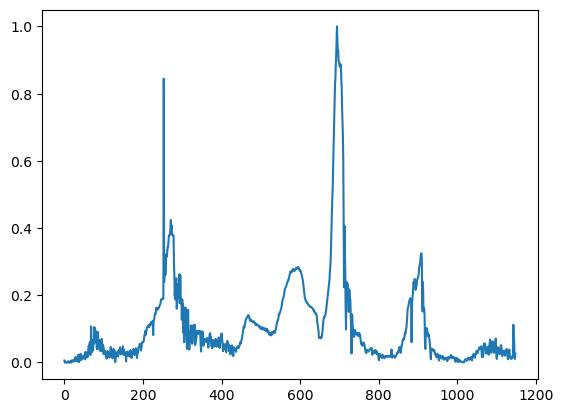

In [223]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
plt.plot(dataset)

In [224]:
# split into train and test sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)    
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

919 230


In [225]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [226]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [227]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [228]:
# create and fit the LSTM network
model = None
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', min_delta=1.e-4)

model = Sequential()
model.add(GaussianNoise(0.01, input_shape=(1, look_back)))
model.add(GRU(100, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(trainX, trainY, epochs=255, batch_size=1, verbose=2,callbacks=[early_stopping])

Epoch 1/255
917/917 - 3s - loss: 0.0241 - 3s/epoch - 3ms/step
Epoch 2/255
917/917 - 1s - loss: 0.0140 - 1s/epoch - 1ms/step
Epoch 3/255
917/917 - 1s - loss: 0.0080 - 1s/epoch - 1ms/step
Epoch 4/255
917/917 - 1s - loss: 0.0048 - 1s/epoch - 1ms/step
Epoch 5/255
917/917 - 1s - loss: 0.0030 - 1s/epoch - 1ms/step
Epoch 6/255
917/917 - 1s - loss: 0.0021 - 1s/epoch - 1ms/step
Epoch 7/255
917/917 - 1s - loss: 0.0018 - 1s/epoch - 1ms/step
Epoch 8/255
917/917 - 1s - loss: 0.0018 - 1s/epoch - 1ms/step
Epoch 9/255
917/917 - 1s - loss: 0.0016 - 1s/epoch - 1ms/step
Epoch 10/255
917/917 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 11/255
917/917 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 12/255
917/917 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 13/255
917/917 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 14/255
917/917 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 15/255
917/917 - 1s - loss: 0.0016 - 1s/epoch - 1ms/step
Epoch 16/255
917/917 - 2s - loss: 0.0016 - 2s/epoch - 2ms/step
E

In [229]:
# make predictions

trainPredict = None
testPredict = None

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

8/8 [==============================] - 0s 997us/step
Train Score: 40.11 RMSE
Test Score: 18.04 RMSE


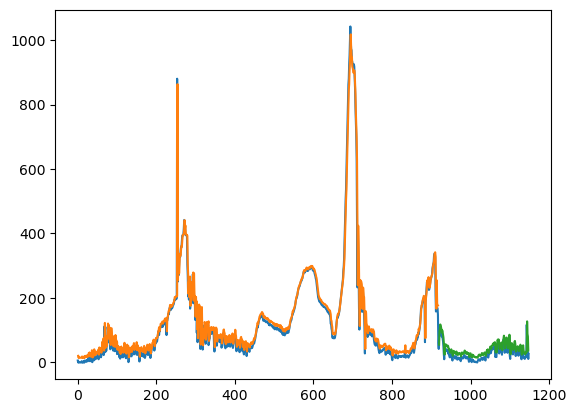

In [230]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

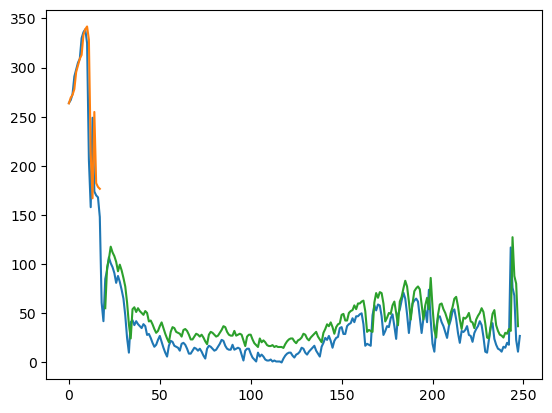

In [231]:
# plot baseline and predictions
l_skip = 900
plt.plot(scaler.inverse_transform(dataset)[l_skip:])
plt.plot(trainPredictPlot[l_skip:])
plt.plot(testPredictPlot[l_skip:])
plt.show()